In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import astropy.table as table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
cvel= const.c.to('km/s').value
import os
#pretty plots
#import seaborn as sns
#sns.set_context("paper")
#sns.set_theme(style="ticks")

#import stellar kinematics module
from  TardisPipeline.utilities  import util_ppxf
#import emission lines module
from  TardisPipeline.utilities  import util_ppxf_emlines
import ppxf.ppxf_util as util
import TardisPipeline as tardis_module
codedir = os.path.dirname(os.path.realpath(tardis_module.__file__))

# this is the LSF of the MUSE data
from  TardisPipeline.readData.MUSE_WFM  import get_MUSE_polyFWHM

%matplotlib inline

In [2]:
#read some test datacube
hdu = fits.open('/Volumes/fbdata2/DATA/Tardis_test/data/NGC0000/NGC0000.fits')
# this is the systemic velocity v = c * z of the galaxy
SYS_VEL_GALAXY =2627.38

# here we read the data and then extract a single summed spectrum over a square region
hdr = hdu['DATA'].header
wav_fit = hdr['CRVAL3'] + np.arange(hdr['NAXIS3']) * hdr['CD3_3']
flux_fit = np.sum(hdu['DATA'].data[:,0:30, 0:30 ], axis=(1,2))

In [3]:
# set up a dictionary which contains some of the key parameters of the ppxf fit
# ABSOLUTE PATHS NEED TO BE UPDATED ACCORDINGLY!!!
configs = {'SSP_LIB':codedir+'/Templates/spectralTemplates/eMILES-noyoung/', # stellar library to use
           'REDSHIFT':SYS_VEL_GALAXY, 'MOM':2,'MC_PPXF':0, 'PARALLEL':0, 
           'ADEG':12, 'MDEG':0,  'MDEG_EMS':8, 'NCPU':1, 
           'ROOTNAME':'test1',#name of the output files
           'EMI_FILE':codedir+'/Templates/configurationTemplates/emission_lines.setup',  # set of emission lines to fit
           'OUTDIR':'/Volumes/fbdata2/DATA/Tardis_test/fit_single_spectrum/', #where do you want results to be saved?
           'MASK_WIDTH':300, #width in km/s to mask around line
           'GAS_MOMENTS':4
          }

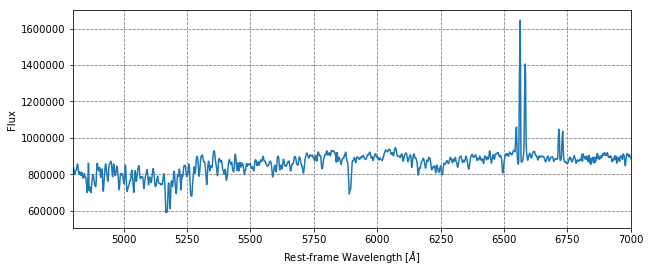

In [4]:
#%matplotlib widget
plt.figure(figsize=(10, 4))
plt.plot(wav_fit /(1+SYS_VEL_GALAXY/cvel), flux_fit)
plt.xlim(4800, 7000)
plt.xlabel('Rest-frame Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.grid(ls='--', color='gray')

In [5]:
#input spectra needs to be log-rebinned
velscale = 50 #size of the pixel in km/s after log-rebinning, you need to choose something that makes sense 
lamrange = np.array([ wav_fit[0], wav_fit[-1]])
log_spec, logLam, velscale = util.log_rebin(lamrange, flux_fit, velscale=velscale)

#in this example we take the error as arbitrary arrays of 1, 
#errors needs to be set it to 9999 when the flux is noy finite
log_err = np.ones(log_spec.shape)
ww = np.isfinite(log_spec)==0
log_err[ww]=9999
log_spec[ww]=0.

# define the LSF of the MUSE data
LSF = get_MUSE_polyFWHM(np.exp(logLam), version="udf10")

# NOW YOU ARE ALL READY TO FIT!!!
# this is the stellar kinematics ppxf wrapper function
ppxf_result = util_ppxf.runModule_PPXF(configs, logLam, log_spec, log_err, LSF)
# this the ppxf wrapper function to simulataneously fit the continuum plus emission lines
util_ppxf_emlines.runModule_PPXF_emlines(configs,logLam, log_spec, 
            log_err, LSF, ppxf_results=ppxf_result)

 - - - - - Running Stellar Kinematics Extraction - - - - - 
 [ RUNNING ] Preparing the stellar population templates
 [ DONE    ] Preparing the stellar population templates
 [ RUNNING ] Running PPXF in serial mode
 [ DONE    ] Running PPXF in serial mode       | 0.0% 
Running PPXF on 1 spectra took 0.34s
 [ RUNNING ] Writing: test1_ppxf.fits
 [ DONE    ] Writing: test1_ppxf.fits
 [ RUNNING ] Writing: test1_ppxf-bestfit.fits
 [ DONE    ] Writing: test1_ppxf-bestfit.fits
 - - - - - Stellar Kinematics done! - - - - -
 - - - - - Running Emission Lines Fitting - - - - - 
 [ RUNNING ] Preparing the stellar population templates
 [ DONE    ] Preparing the stellar population templates
 [ RUNNING ] Running PPXF in serial mode
Some gas templates are identically zero:                     | 0.0% 
[False False False False False False False False False  True False False]
Best Fit:       Vel     sigma        h3        h4
 comp. 0:       -15       103
 comp. 1:       -14        92    -0.012     0.001
 c

(4800, 7000)

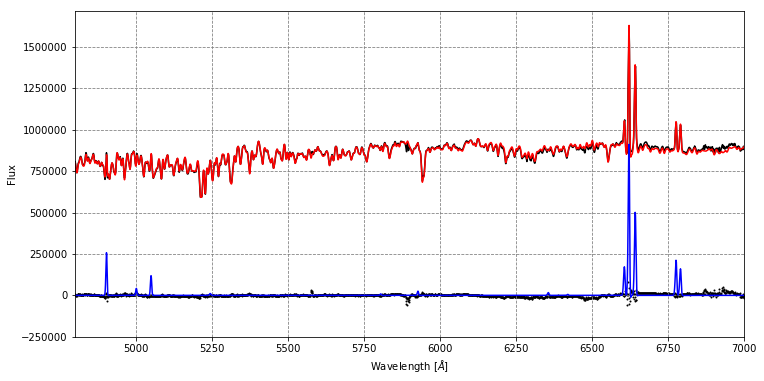

In [6]:
# read the output file which contains the best-fit from the emission lines fitting stage
ppxf_bestfit_gas=configs['OUTDIR']+configs['ROOTNAME']+'_ppxf-bestfit-emlines.fits'
hdu3 = fits.open(ppxf_bestfit_gas)
bestfit_gas = hdu3['FIT'].data["BESTFIT"][0]
mask=(hdu3['FIT'].data['BESTFIT'][0]==0)
gas_templ =hdu3['FIT'].data["GAS_BESTFIT"][0]

plt.figure(figsize=(12,6))
plt.plot(np.exp( logLam), log_spec, c='k', label='data')
plt.plot(np.exp( logLam), bestfit_gas, c='r', label='best fit model')
plt.plot(np.exp( logLam ), gas_templ, c='b', label='gas model')
plt.scatter(np.exp( logLam ), log_spec-bestfit_gas, c='k', label='residuals', s=1)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.grid(ls='--', color='gray')
plt.xlim(4800, 7000)

In [7]:
#if you want to access emission line fluxes you can load the emlines file
emlines=configs['OUTDIR']+configs['ROOTNAME']+'_emlines.fits'
hdu4 = fits.open(emlines)
ems = table.Table(hdu4['EMLDATA_DATA'].data)
ems

<Table length=1>
BIN_ID       V_STARS2      ...       SII6730_H3             SII6730_H4      
int32        float64       ...        float64                float64        
------ ------------------- ... ---------------------- ----------------------
     0 -14.665867490603292 ... 1.2698903378584333e-06 1.4370460593939492e-06